## Identification of Partisan Words

Once we have scraped samples of liberal and conservative articles, we can conduct a bag-of-words analysis.  We will attempt to identify words that are distinctive to each sample, such that the presence or absence of such words gives the most information about an articles classification.

We begin by importing the packages we will use and loading our scraped data.

In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
import numpy as np
import tqdm

import matplotlib.pyplot as plt
import wordcloud
from PIL import Image

C:\Users\dmv15\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
articles_df = pd.read_csv('article_scraping/Articles_70000.csv')

Now we want to split up our sample into liberal and conservative articles and tokenize these articles into individual words.  We make use of the keras Tokenizer for each class of article, conservative and liberal, as well as for all articles combined.  This will allow us to compute simple statistics of word usage later on.

In [3]:
cons_articles = articles_df[articles_df['Affiliation (0=conservative)']==0]['Article Text'].fillna(' ').tolist()
lib_articles = articles_df[articles_df['Affiliation (0=conservative)']==1]['Article Text'].fillna(' ').tolist()

cons_articles = [a for a in cons_articles if len(a)>100]
lib_articles = [a for a in lib_articles if len(a)>100]

In [4]:
lib_token = Tokenizer()
cons_token = Tokenizer()
all_token = Tokenizer()

lib_token.fit_on_texts(lib_articles)
cons_token.fit_on_texts(cons_articles)
all_token.fit_on_texts(cons_articles+lib_articles)

One way of determining the distinctiveness of words is to compute the mutual information (MI) of a word and a class (https://nlp.stanford.edu/IR-book/html/htmledition/mutual-information-1.html).  This quantifies how much the presence of a given word tells us about its class membership.  Words with a large MI, then, will be good identifiers of its document's class membership and therefore can be said to be dinstinctive to that class.

Following the article above, I created a function to compute the word-class table for any word and class in our documents given the tokenizer's we called above.  I also created a function to compute the MI from this word-class table.  We'll load those both here.

In [5]:
from mutual_information import class_table, mutual_info

Now we want to loop through our entire vocabulary and compute the MI of each word as it relates to liberal membership and conservative membership.  We only care about MI if the presence of a word implies class membership, so we set any values of MI where instead the absence of a word implies membership to zero.  This allows us to find separate sets of distinctive liberal words and distinctive conservative words.

In [6]:
words=np.array([w for w,val in all_token.word_index.items()])

MI_lib, MI_cons = np.zeros([len(words),]), np.zeros([len(words),])

for n,word in enumerate(tqdm.tqdm(words)):
    MI_lib[n] = mutual_info(class_table(word,lib_token,len(lib_articles),cons_token,len(cons_articles)))
    MI_cons[n] = mutual_info(class_table(word,cons_token,len(cons_articles),lib_token,len(lib_articles)))

100%|██████████| 313333/313333 [00:14<00:00, 21996.14it/s]


Now that we have the associated MI of each word we can examine the results.  We are interested in identifying the most distinctive words for each class, which are just the terms with the largest MI.  We print out the top 50 conservative and liberal words below.

In [7]:
print(words[np.argsort(MI_cons)[-50:]])
print(words[np.argsort(MI_lib)[-50:]])

['jihad' 'here' 'identity' 'free' 'sex' 'conservatism' 'victim' 'faculty'
 '“gender' 'why' 'townhall' 'radical' 'here’s' 'christians' 'evil' 'left'
 'men' 'life' 'rape' 'gender' 'breitbart' 'professors' 'islamic' 'male'
 'feminist' 'newsbusters' 'student' 'police' 'amnesty' 'religion'
 'cultural' 'com' 'society' 'god' 'campuses' 'conservatives' 'left’s'
 'caller' 'liberty' 'aliens' 'islam' 'liberal' 'culture' 'liberals' '–'
 'students' 'leftists' 'campus' 'follow' 'leftist']
['meeting' 'invalid' 'special' 'republicans' '2016' 'advisers' 'russian'
 'administration' 'subscribe' 'month' 'ap' 'advertisement' 'clinton'
 'inbox' 'senate' 'russia' "times's" 'office' 'week' 'getty' 'clicking'
 'vermont' 'director' 'aides' 'candidate' 'story\r' 'subscribing'
 'committee' 'newsletter' 'lawmakers' 'trump’s' 'white' 'election'
 'washington' 'former' 'bernie' 'said' 'secretary' 'newsletters'
 'democratic' 'adviser' 'sanders' 'presidential' "trump's" 'republican'
 'president' 'house' 'campaign' 'don

OK great, these terms look reasonable.  This implies that articles discussing the 2016 trump campaign identify liberal articles, whereas articles about leftist campus culture identify conservative articles. 

We can also create a word cloud with our bag-of-words representation, with the size of each word scaled by it's MI.  We do this below for both liberal words and conservative words using the wordcloud package.

In [8]:
lib_mask = np.array(Image.open('democrat_logo2.jpg'))
cons_mask = np.array(Image.open('republican_logo.jpg'))

lib_dic, cons_dic = {}, {}
for n,w in enumerate(words):
    lib_dic[w] = MI_lib[n]
    cons_dic[w] = MI_cons[n]

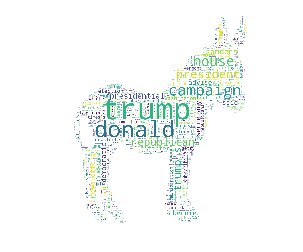

In [9]:
wc = wordcloud.WordCloud(background_color="white",mask=lib_mask,random_state=5,max_words=2000).fit_words(lib_dic)

plt.imshow(wc)
plt.axis("off")

wc.to_file('Liberal_Word_Cloud.png')

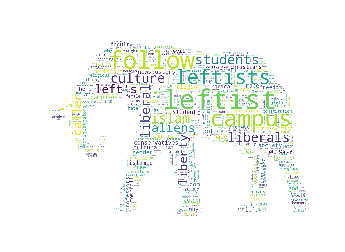

In [10]:
wc = wordcloud.WordCloud(background_color="white",mask=cons_mask,random_state=5,max_words=2000).fit_words(cons_dic)

plt.imshow(wc)
plt.axis("off")

wc.to_file('Conservative_Word_Cloud.png')